Input the pickle file, then fit the model in different conditions- acute versus chronic, high diversity vs low diversity of trauma.

In [7]:
import codecs
import sklearn
import glob
import os
import time
import re
from datetime import datetime
import multiprocessing as mp
from multiprocessing import Pool
import pickle
import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
#import pymc as pt

In [8]:
def load_saved_csvs(out_dir=None, keys=None, assign=False):
    import os, pandas as pd
    out_dir = out_dir or os.path.join(os.getcwd(), "exports", "csv")
    keys = keys or ['rwlrnEstArr','rwlrnOCArr','rwlrnSumm','lrnEstArr','lrnOCArr','lrnSumm']
    dfs = {k: pd.read_csv(os.path.join(out_dir, f"{k}.csv")) for k in keys if os.path.exists(os.path.join(out_dir, f"{k}.csv"))}
    if assign:
        globals().update(dfs)
    return dfs

In [9]:

def genModelPreds(outcomes,lr,p0):
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lr * (np.array(outcomes.iloc[:,ii]) - pred[:,ii])
    return pred           


def calcActProbs(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i+(1-preds)*-i for i in chVals]
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i
    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]
    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    
    return actProbArr

#pt = pytensor
def choiceprob (theta, u): #probability calculation #cumulative probability 
    p_cum_2 = 1/(1+pd.exp(-theta (u[:, :, 1] + u[:, :, 2]+ u[:,:, 3] + u[:, :, 4]- u[:, :, 0]))) #p of choosing 2-5 over 1 # shape (n_sub, 18)
    p_cum_3 = 1/(1+ pd.exp(-theta (u[:,:, 2]+ u[:, :, 3] + u[:, :, 4]- u[:,:, 0] - u[:,:, 1]))) #p of choosing 3-5 over 1-2 
    p_cum_4 = 1/(1+ pt.exp(-theta (u[:,:, 3] + u[:, :, 4] - u[:,:, 0]- u[:, :, 1] - u[:, :, 2]))) #p of choosing 4-5 over 1-3 #probability for each trial & option p_11 
    p_cum_5 = 1 /(1+ pt.exp(-theta (u[:,:, 4]- u[:,:, 0]- u[:, :, 1]- u[:, :, 2] - u[:, :, 3]))) #p of choosing 5 over 1-5 #probability for each trial & option p_11 
    p_1 = 1- p_cum_2 
    p_2= p_cum_2 - p_cum_3 
    p_3= p_cum_3 - p_cum_4 
    p_4= p_cum_4 - p_cum_5
    p_5= p_cum_5
    p = pt.stack([p_1, p_2, p_3, p_4,p_5], axis=2) # shape (n_sub, 18, 4) return p

def calcNegLogLike(choices, actProbs, penalty=1e6):
    import numpy as np, pandas as pd
    # canonicalize choices to integer ndarray (rows=subjects, cols=trials)
    choices = choices.copy().reset_index(drop=True)
    ch = choices.values.astype(int)
    n_rows, n_cols = ch.shape

    # convert actProbs to numpy arrays and validate shapes
    probs_arrs = [np.array(p) for p in actProbs]
    for k, arr in enumerate(probs_arrs):
        if arr.shape != ch.shape:
            raise ValueError(f"actProbs[{k}] shape {arr.shape} != choices shape {ch.shape}")

    # build matrix of predicted probs for the observed choices (nan if invalid)
    chProbs = np.full(ch.shape, np.nan, dtype=float)
    for k, arr in enumerate(probs_arrs):
        mask = (ch == (k + 1))            # boolean mask
        chProbs[mask] = arr[mask]         # positional assignment avoids label alignment issues

    # compute negative log-likelihood, replacing non-finite with heavy penalty
    with np.errstate(divide='ignore', invalid='ignore'):
        nll = -np.log(chProbs)
    nll[~np.isfinite(nll)] = penalty
    nll_sum = np.sum(nll, axis=1)   # sum over trials per subject

    # return per-subject nll and a DataFrame of chosen probs for debugging
    chProbs_df = pd.DataFrame(chProbs, columns=choices.columns)
    return nll_sum, chProbs_df

def chanceLikelihood(choices, chanceP=0.2, penalty=1e6):
    import numpy as np, pandas as pd
    choices = choices.copy().reset_index(drop=True)
    ch = choices.values.astype(int)
    # non-zero choices get chanceP; zeros (if any) treated as missing -> penalized
    chProbs = np.full(ch.shape, np.nan, dtype=float)
    nz_mask = (ch != 0)
    chProbs[nz_mask] = float(chanceP)
    with np.errstate(divide='ignore', invalid='ignore'):
        nll = -np.log(chProbs)
    nll[~np.isfinite(nll)] = penalty
    nll_sum = np.sum(nll, axis=1)
    return nll_sum


#single LR sofented with sigmoid and single SM model
def optimizeLR_sft(params, choices, outcomes):
    p = np.asarray(params).ravel()
    lrp = float(p[0])
    sm = float(p[1])
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    if np.any(np.array((lr,sm))<0) or lr>1:
        nLL=10e30
        return nLL
    mod=genModelPreds(outcomes,lr,initPred)
    actProbs=calcActProbs(mod, sm)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    return np.sum(nLL)

#single LR sofented with sigmoid and fixed SM model
def optimizeLR_sft_fixedSM(params, choices, outcomes, smax=1, initPred=.5):
    p = np.asarray(params).ravel()
    lrp = float(p[0])
    smax = float(smax)
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
    mod=genModelPreds(outcomes,lr,initPred)
    actProbs=calcActProbs(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    return np.sum(nLL)


def bootstrap_correlation_ci(series1, series2, n_bootstraps=10000, ci=95):
    indices = np.arange(len(series1))
    correlations = []
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_series1 = series1[boot_indices]
        boot_series2 = series2[boot_indices]
        r, _ = stats.pearsonr(boot_series1, boot_series2)
        correlations.append(r)
    
    lower = np.percentile(correlations, (100 - ci) / 2)
    upper = np.percentile(correlations, 100 - (100 - ci) / 2)
    return lower, upper

# And update your function definition to:
def bootstrap_mean_ci(series, n_bootstraps=1000, ci=95):
    means = []
    indices = np.arange(len(series))
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_series = series.iloc[boot_indices]
        means.append(np.mean(boot_series))
    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return lower, upper

def sigmoid(x,a,b,c):
    y=a+b/(1+np.exp(-c*(x-50)))
    return y

In [10]:
def load_workspace(filename):
 with open(filename, 'rb') as f:
  data_loaded = pickle.load(f)
 return data_loaded

data = load_workspace('data/pklForTheo.pkl')

In [21]:

n_sub = 363
n_trials = 22
n = n_sub * n_trials

nll_fixed = 168203.13
k_fixed = 1
nll_fit = 166018.79
k_fit = 2

def aic(nll, k):
    return 2*k + 2*nll

def bic(nll, k, n):
    return k * np.log(n) + 2*nll

print("n observations:", n)
print("AIC fixed:", aic(nll_fixed, k_fixed))
print("AIC fit:  ", aic(nll_fit, k_fit))
print("ΔAIC (fit - fixed):", aic(nll_fit, k_fit) - aic(nll_fixed, k_fixed))

print("BIC fixed:", bic(nll_fixed, k_fixed, n))
print("BIC fit:  ", bic(nll_fit, k_fit, n))
print("ΔBIC (fit - fixed):", bic(nll_fit, k_fit, n) - bic(nll_fixed, k_fixed, n))

n observations: 7986
AIC fixed: 336408.26
AIC fit:   332041.58
ΔAIC (fit - fixed): -4366.679999999993
BIC fixed: 336415.2454452876
BIC fit:   332055.5508905753
ΔBIC (fit - fixed): -4359.694554712332


In [11]:
## Now the lottery data
rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm']


## Now the trust data
lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']


In [12]:

datForAndrea = pd.read_csv('data/datForAndreaMerged.csv', index_col=0)

print(datForAndrea.shape)
print(datForAndrea.columns)
print("distFromMedQA_lowMC_ltMADCutOff_goodSub:", datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'].sum())
print("distFromMedQAAll_lowMC_ltMADCutOff_goodSub:", datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'].sum())

(418, 48)
Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'Age', 'Race',
       'HLS_ethnicity', 'BirthSex', 'Education', 'LEC-A_6', 'LEC-A_7',
       'LEC-A_8', 'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17',
       'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age',
       'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age', 'trust_rat_mean',
       'trust_rat_std', 'trust_subjLR_bOC', 'trust_subjD_bOC',
       'trust_subjNLL_bOC', 'trust_subjLRTp_bOC', 'trust_subjLR_3prm',
       'trust_subjD_3prm', 'trust_subjp0_3prm', 'trust_subjNLL_3prm',
       'trust_subjLRTp_3prm', 'trust_BIC_bOC', 'trust_BIC_3prm',
       'lott_subjLR_bOC', 'lott_subjD_bOC', 'lott_subjNLL_bOC',
       'lott_subjLRTp_bOC', 'lott_subjLR_3prm', 'lott_subjD_3prm',
       'lott_subjp0_3prm', 'lott_subjNLL_3prm', 'lott_subjLRTp_3prm',
       'lott_BIC_bOC', 'lott_BIC_3prm', 'trustDiscrim_fitOffset',
       'trustDiscrim_fitScale', 'trustDiscrim_fitSlop

In [13]:
subj_ids = rwlrnOCArr['PID'].unique()

FITTING...
subj: 5f2f86864fd821374b4367bc
subj: 61492ac26b91b5b11ba2c88b
subj: 60234c1d5a0cf81cba76ce5d
subj: 6362aca86b740b1ec4cb6efb
subj: 60fcd2b146529d02f1566012
subj: 63ed12d2c25b08ba24fe8a41
subj: 5d412a9013864b0015b14b31
subj: 62ec219e5f3634408fb35580
subj: 594936ad4152bf0001bfd5cd
subj: 63d842d3e9626bd5fe5c17b1
subj: 631bc422eec20143118ad66b
subj: 58016c9f551314000145af58
subj: 63d1c10210ce566ce71616e8
subj: 5e55e83cc65ccb5ed547cb04
subj: 63e5b3e89a3823139cb9d35e
subj: 6400ea4cec0b310140841b2d
subj: 6352b3c968388ef86f3556db
subj: 63dc7b5bf451a34177b66c66
subj: 63d881ab484805569b553bd8
subj: 63d43dc4b4b7a0e426a381cd
subj: 5e7abb2c6c89e4000a180b4a
subj: 63d42c21dc6f4d60e34cc337
subj: 62f6bc18e456bdf4bc90dd7b
subj: 63d6873b65a6170d64a652f6
subj: 633fa968afc8d3d2c0d8745c
subj: 5c3161130cfe9a00012f71ff
subj: 5f1f3581b5cf3e103cc545c9
subj: 63d42387aba51e699ab9ce5c
subj: 5fa935b3d330fa0429da624a
subj: 63d97863bc1e08294519edd8
subj: 60fefd59226b2b1d87bc36db
subj: 5f5691fb24d1090e6bcdf1

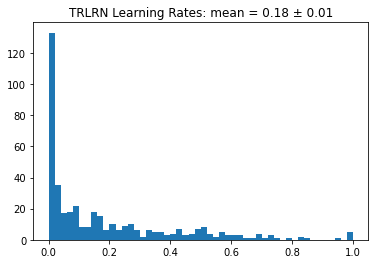

,totalTime,rat_mean,rat_std,rat_r1r2_corr_r,rat_r1r2_corr_p,frat_r1r2_corr_r,frat_r1r2_corr_p,subjLR,subjSM,subjNLL,...,qa:rat_blurEv,qa:dec_%rt<300,qa:dec_%rt>10000,qa:dec_%Conseqs,qa:dec_instruxDur,qa:dec_blurEv,qa:frat_%rt<300,qa:frat_%rt>10000,qa:frat_%Conseqs,qa:frat_instruxDur
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
5f2f86864fd821374b4367bc,565.772,5.250000,3.197589,-0.163286,3.886012e-01,-0.212007,0.508294,0.007573,0.200000,208.689941,...,0.0,0.750000,0.0,0.946970,60.43,0.0,0.166667,0.0,0.666667,13.94
61492ac26b91b5b11ba2c88b,631.332,4.216667,2.597859,0.951848,6.564741e-16,0.534606,0.073335,0.041917,0.200000,169.013616,...,1.0,0.000000,0.0,0.196970,89.20,0.0,0.000000,0.0,0.083333,17.42
60234c1d5a0cf81cba76ce5d,800.233,4.833333,2.694418,0.806974,7.179994e-08,0.404991,0.191561,0.579932,2.862536,205.744529,...,0.0,0.015152,0.0,0.356061,135.66,0.0,0.000000,0.0,0.250000,15.30
6362aca86b740b1ec4cb6efb,878.497,4.916667,3.416270,-0.531884,2.485874e-03,0.304439,0.335992,0.043259,1.831505,211.789180,...,2.0,0.060606,0.0,0.318182,170.04,1.0,0.166667,0.0,0.000000,26.10
60fcd2b146529d02f1566012,529.800,5.383333,1.949286,0.634095,1.682292e-04,0.795261,0.001986,0.061710,0.593636,198.786030,...,2.0,0.083333,0.0,0.537879,48.83,0.0,0.000000,0.0,0.083333,14.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641359eb0e2dc93999637e35,912.944,5.316667,1.808564,0.691111,2.354567e-05,0.817614,0.001160,0.003360,0.200000,211.961250,...,0.0,0.000000,0.0,0.075758,165.21,0.0,0.000000,0.0,0.083333,20.75
63d2bc12a843f8466a8f83e0,617.354,4.100000,2.312091,0.778739,4.021243e-07,0.724699,0.007672,0.605416,1.648766,193.389774,...,0.0,0.053030,0.0,0.333333,89.63,0.0,0.000000,0.0,0.083333,14.71
610b416fd4f5d1dcfaa28d7a,803.327,3.633333,1.948199,0.464978,9.626281e-03,-0.061426,0.849593,0.434256,1.348783,188.575441,...,0.0,0.015152,0.0,0.181818,124.38,0.0,0.000000,0.0,0.083333,31.62


In [14]:
# # FIT THE Trust Learning DATA WITH A SINGLE LEARNING RATE MODEL

for key in ['rwlrnEstArr', 'rwlrnOCArr']:
    df = data[key]
    if 'PID' not in df.columns:
        df['PID'] = subj_ids
    data[key] = df
smax=1
lrRange=np.linspace(-10,10,5)
smRange=np.linspace(0.01,10,5)
fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
initPred=0.5
print('FITTING...')
for PID in lrnEstArr.PID.unique():
    print('subj: {}'.format(PID))
    estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
    ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    lrs_nll=np.inf
    for lrs, sm in zip(lrRange, smRange):
        result_s=sp.optimize.minimize(optimizeLR_sft, (lrs, sm),(estDat, ocDat),bounds=((-10,10),(0.2, 5)))
        if result_s.fun < lrs_nll:
            lrs_nll = result_s.fun
            lrs_val = result_s.x[0]
            sm_val = result_s.x[1]
 
    lrnSumm.loc[PID,'subjLR']=np.exp(lrs_val)/(np.exp(lrs_val)+1)
    lrnSumm.loc[PID,'subjSM']=sm_val
    lrnSumm.loc[PID,'subjNLL']=lrs_nll
    chncNLL=np.sum(chanceLikelihood(estDat))
    lrnSumm.loc[PID, 'subjLRTp']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subjNLL']),1)

lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')

# build the plot
fig, ax = plt.subplots()
ax.hist(lrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
ax.set(title='TRLRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(lrnSumm.subjLR.mean(), lrnSumm.subjLR.std()/np.sqrt(lrnSumm.subjLR.count())))

plt.show()
lrnSumm

FITTING...
subj: 5f2f86864fd821374b4367bc
subj: 61492ac26b91b5b11ba2c88b
subj: 60234c1d5a0cf81cba76ce5d
subj: 6362aca86b740b1ec4cb6efb
subj: 60fcd2b146529d02f1566012
subj: 63ed12d2c25b08ba24fe8a41
subj: 5d412a9013864b0015b14b31
subj: 62ec219e5f3634408fb35580
subj: 594936ad4152bf0001bfd5cd
subj: 63d842d3e9626bd5fe5c17b1
subj: 631bc422eec20143118ad66b
subj: 58016c9f551314000145af58
subj: 63d1c10210ce566ce71616e8
subj: 5e55e83cc65ccb5ed547cb04
subj: 63e5b3e89a3823139cb9d35e
subj: 6400ea4cec0b310140841b2d
subj: 6352b3c968388ef86f3556db
subj: 63dc7b5bf451a34177b66c66
subj: 63d881ab484805569b553bd8
subj: 63d43dc4b4b7a0e426a381cd
subj: 5e7abb2c6c89e4000a180b4a
subj: 63d42c21dc6f4d60e34cc337
subj: 62f6bc18e456bdf4bc90dd7b
subj: 632aaef27780d596dc7e0a9f
subj: 63d6873b65a6170d64a652f6
subj: 633fa968afc8d3d2c0d8745c
subj: 5c3161130cfe9a00012f71ff
subj: 5f1f3581b5cf3e103cc545c9
subj: 63d42387aba51e699ab9ce5c
subj: 5fa935b3d330fa0429da624a
subj: 63d97863bc1e08294519edd8
subj: 60fefd59226b2b1d87bc36

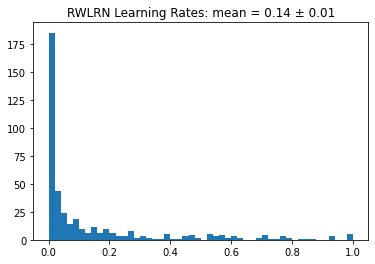

In [15]:
# # FIT THE Trust Learning DATA WITH A SINGLE LEARNING RATE MODEL

for key in ['rwlrnEstArr', 'rwlrnOCArr']:
    df = data[key]
    if 'PID' not in df.columns:
        df['PID'] = subj_ids
    data[key] = df
smax=1
lrRange=np.linspace(-10,10,5)
smRange=np.linspace(0.01,10,5)
fit_lrDF_subj=pd.DataFrame(index=rwlrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
initPred=0.5
print('FITTING...')
for PID in rwlrnEstArr.PID.unique():
    print('subj: {}'.format(PID))
    rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
    rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    lrs_nll=np.inf
    for lrs, sm in zip(lrRange, smRange):
        result_s=sp.optimize.minimize(optimizeLR_sft, (lrs, sm),(rwestDat, rwocDat),bounds=((-10,10),(0.2, 5)))
        if result_s.fun < lrs_nll:
            lrs_nll = result_s.fun
            lrs_val = result_s.x[0]
            sm_val = result_s.x[1]
 
    rwlrnSumm.loc[PID,'subjLR']=np.exp(lrs_val)/(np.exp(lrs_val)+1)
    rwlrnSumm.loc[PID,'subjSM']=sm_val
    rwlrnSumm.loc[PID,'subjNLL']=lrs_nll
    chncNLL=np.sum(chanceLikelihood(rwestDat))
    rwlrnSumm.loc[PID, 'subjLRTp']=stats.chi2.sf(2*(chncNLL-rwlrnSumm.loc[PID,'subjNLL']),1)

rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')

# build the plot
fig, ax = plt.subplots()
ax.hist(rwlrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
ax.set(title='RWLRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(rwlrnSumm.subjLR.mean(), rwlrnSumm.subjLR.std()/np.sqrt(rwlrnSumm.subjLR.count())))

plt.show()


In [16]:
choices= estDat

Now I'm going to break up the scales and score them. I will score the LEC, the CTQ, and then see how many of the LEC B is in childhood.

In [17]:
lrnSumm.to_csv('data/lrnSumm_fitSM.csv')
rwlrnSumm.to_csv('data/rwlrnSumm_fitSM.csv')

In [18]:
lrnSumm = pd.read_csv('data/lrnSumm_fitSM.csv')
rwlrnSumm = pd.read_csv('data/rwlrnSumm_fitSM.csv')

In [19]:
totalNLL = lrnSumm['subjNLL'].sum() + rwlrnSumm['subjNLL'].sum()
print(f"Total NLL across both datasets: {totalNLL:.2f}")

Total NLL across both datasets: 166018.79


In [20]:
# create Simulated social data and use to ind socially specific params


#distFromMedQAAll_lowM

oneLRLOT = rwlrnSumm
oneLRTRUST = lrnSumm
allLrnSumm = pd.DataFrame(index=oneLRTRUST.index)
#sort by good candidates
good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in allLrnSumm.index]
oneLRLOT = oneLRLOT.loc[valid_candidates]
oneLRTRUST = oneLRTRUST.loc[valid_candidates]


import pandas as pd
import statsmodels.api as sm

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_LR': oneLRLOT['subjLR'],
    'trust_LR': oneLRTRUST['subjLR']
}).dropna()

# Define predictors and outcome
X = df['lottery_LR']
y = df['trust_LR']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()

print(model.summary())

#for sm

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_SM': oneLRLOT['subjSM'],
    'trust_SM': oneLRTRUST['subjSM']
}).dropna()

# Define predictors and outcome
X = df['lottery_SM']
y = df['trust_SM']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()
print(model.summary())
#for D

allLrnSumm['subjLR_3prm_predsoc']= oneLRTRUST['subjLR']- (0.2142*oneLRLOT['subjLR'] + 0.1561)



ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:

#now with regression 

allLrnSumm['subjLR_tr']=oneLRTRUST['subjLR']
allLrnSumm['subjSM_tr']=oneLRTRUST['subjSM']
allLrnSumm['subjLR_rw']=oneLRLOT['subjLR']
allLrnSumm['subjSM_rw']=oneLRLOT['subjSM']


In [ ]:
import numpy as np
from scipy.special import logit, expit
import statsmodels.api as sm
def residualize_lr(lr_series, covariate_series, eps=1e-6):
    """Residualize a learning-rate series in (0,1) by regressing the raw lr on covariate and returning residuals shifted to the original scale."""
    cov = covariate_series  # align indices
    X = sm.add_constant(cov)
    model = sm.OLS(lr_series, X, missing='drop').fit()
    resid = model.resid
   
    return resid, model

def residualize_positive(pos_series, covariate_series, eps=1e-8):
    """Residualize a strictly-positive series (e.g. softmax temp) by regressing log(value) and exponentiating residuals."""
    val = pos_series.clip(lower=eps).astype(float)
    cov = covariate_series.reindex(val.index).astype(float)
    X = sm.add_constant(cov)
    model = sm.OLS(np.log(val), X, missing='drop').fit()
    resid = model.resid
    resid_back = pd.Series(np.exp(resid), index=resid.index)
    return resid_back, model

# Usage examples (replace series names with your actual columns/objects):
allLrnSumm['subjLR_predsoc'], m_lr = residualize_lr(oneLRTRUST['subjLR'], oneLRLOT['subjLR'])
allLrnSumm['subjSM_predsoc'], m_sm = residualize_positive(oneLRTRUST['subjSM'], oneLRLOT['subjSM'])

In [ ]:
#desctiptive stats for Social, nonsocial, and socially specific params, using 95% confidence intervals
import numpy as np
import scipy.stats as stats
good_candidates = datForAndrea[datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in allLrnSumm.index]

allLrnSumm = allLrnSumm.loc[valid_candidates]
print(len(allLrnSumm))


#violin plots for all of these

def plot_violin_with_jitter_and_ci(df, n_bootstraps=10000, ci=95, ylim=None, yticks=None, figsize=(6,6)):
    """
    Plots a violin plot with jittered data, mean, and bootstrapped confidence intervals.
    
    Parameters:
    - df: DataFrame, data to plot with each column being a separate dataset.
    - bootstrap_mean_ci: function, used to calculate mean and CI.
    - n_bootstrap: int, number of bootstrap iterations for CI calculation.
    - ci: float, the confidence interval percentage.
    """
    # Set the figure size and create a violin plot
    plt.figure(figsize=figsize)
    
    # Create violin plots for each column
    sns.violinplot(data=df, inner=None, color="0.8", cut=0)
    
    # Add jittered points
    for i, col in enumerate(df.columns):
        # Jittered x positions
        jittered_x = np.random.normal(i, 0.06, size=len(df))
        plt.scatter(jittered_x, df[col], alpha=0.5, color='k', s=10)
        
        # Calculate mean and CI using the provided function
        lower_ci, upper_ci = bootstrap_mean_ci(df[col], n_bootstraps, ci)
        mean=df[col].mean()
        
        # Plot mean and CI
        plt.errorbar(i+.4, mean, yerr=[[mean - lower_ci], [upper_ci - mean]], fmt='d', color='#FF8F00', capsize=5)
    

    # Set the x-axis labels to the column names
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns)
    # Adjust tick parameters to hide tick marks but keep labels
    plt.tick_params(axis='x', length=0)  # Set tick length to 0 for x-axis

    if ylim is not None:
        plt.ylim(ylim)

    # Optionally set custom yticks if provided
    if yticks is not None:
        plt.yticks(yticks)
    
    # Add a horizontal line at zero
    plt.axhline(y=0, color='Gray', linestyle='--')

    # Adjust y-axis ticks to be inside and remove tick labels
    plt.tick_params(axis='y', direction='in', labelleft=False)  # 'labelleft=False' removes the y-axis tick labels
    
    plt.tight_layout()
    plt.savefig(f'dist{i}.svg', format='svg')
    plt.show()

len(allLrnSumm)

311


311

In [ ]:


#plot_violin_with_jitter_and_ci(allLrnSumm[['subjLR_3prm','rwsubjLR_3prm','subjLR_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(allLrnSumm[['subjp0_3prm','rwsubjp0_3prm','subjSM_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(allLrnSumm[['subjLR_tr','subjLR_rw','subjLR_predsoc','subjLR_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(allLrnSumm[['subjSM_tr','subjSM_rw','subjSM_predsoc']], ylim=[-20,20], yticks=[-1,0,1])




NameError: name 'plot_violin_with_jitter_and_ci' is not defined

<span style="font-size: 48px;">1: Trauma Load</span>

In [ ]:
qDat = data['qDat']
# Take all qDat columns that start with 'LEC-A'
lec_df = qDat.loc[:, qDat.columns.str.startswith('LEC')]
#lec_df = datForAndrea.loc[:, datForAndrea.columns.str.startswith('LEC')]



#lec_cols_interest = ['LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_16']
ALL_LEC = ['LEC-A_1','LEC-A_2','LEC-A_3','LEC-A_4','LEC-A_5','LEC-A_6', 'LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_12','LEC-A_14','LEC-A_15','LEC-A_16','LEC-A_17']
ALL_LEC_AGE = [
    'LEC-1-FU-Age', 'LEC-2-FU-Age', 'LEC-3-FU-Age', 'LEC-4-FU-Age', 'LEC-5-FU-Age',
    'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age',
    'LEC-11-FU-Age', 'LEC-12-FU-Age', 'LEC-14-FU-Age', 'LEC-15-FU-Age', 'LEC-16-FU-Age', 'LEC-17-FU-Age'
]
lec_cols_interest = ['LEC-A_6', 'LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17']
lec_cols_interest_witness = ['LEC-A_6','LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11','LEC-A_15', 'LEC-A_17']
lec_age_cols = ['LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age']
lec_age_witness = ['LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-15-FU-Age', 'LEC-16-FU-Age']
lec_chronicity_cols = ['LEC-6-FU-Chronicity', 'LEC-7-FU-Chronicity', 'LEC-8-FU-Chronicity', 'LEC-9-FU-Chronicity', 'LEC-10-FU-Chronicity', 'LEC-11-FU-Chronicity', 'LEC-16-FU-Chronicity']


In [ ]:

def experienced(val):
    if pd.isnull(val):
        return 0
    try:
        return 1 if "1" in str(val).split(",") else 0
    except:
        return 0


def experienced_in_childhood(age, val):
    # Return 1 if age < 18 and '1' is anywhere in val (handles comma-separated or other digits)
    try:
        if float(age) < 18 and ('1' in str(val).split(',')):
            return 1
    except:
        pass
    return 0

def witnessed(val):
    if pd.isnull(val):
        return 0
    try:
        return 1 if "2" in str(val).split(",") else 0
    except:
        return 0


def witnessed_and_experienced(val):
    if pd.isnull(val):
        return 0
    try:
        val_set = set(str(val).split(","))
        return 1 if "1" in val_set and "2" in val_set else 0
    except:
        return 0
    

def witnessed_and_exper_child(val, age):
    if pd.isnull(val):
        return 0
    try:
        val_set = set(str(val).split(","))
        return 1 if float(age) < 18 and "1" in val_set and "2" in val_set else 0
    except:
        return 0
    

def witnessed_in_childhood(age, val):
    # Return 1 if age < 18 and '2' is anywhere in val (handles comma-separated or other digits)
    try:
        if float(age) < 18 and ('2' in str(val).split(',')):
            return 1
    except:
        pass
    return 0

def is_chronic(val, exp_val):
    if pd.isnull(val) or pd.isnull(exp_val):
        return 0
    try:
        # Only count as chronic if experienced ("1" in exp_val) and chronicity == 2
        if "1" in str(exp_val).split(",") and float(val) == 2:
            return 1
        else:
            return 0
    except:
        return 0
    
lec_df['LEC-3-FU-Age'] = lec_df['LEC-3-FU-Age'].astype(str).str.replace(r'^7', '', regex=True)



interpersonal_load = lec_df[lec_cols_interest].applymap(experienced).sum(axis=1)

lec_df['interpersonal_load'] = interpersonal_load
lec_df['interpersonal_childhood'] = [
    sum(experienced_in_childhood(row[age_col], row[lec_col]) for age_col, lec_col in zip(lec_age_cols, lec_cols_interest))
    for _, row in lec_df.iterrows()
]

lec_df['IPT_yn'] = (lec_df['interpersonal_load'] > 0).astype(int)

lec_df['IPT_child_yn'] = (lec_df['interpersonal_childhood'] > 0).astype(int)

lec_df['Lec_Total_Childhood'] = [
    sum(
        experienced_in_childhood(row[age_col], row[lec_col])
        for age_col, lec_col in zip(ALL_LEC_AGE, ALL_LEC)
    )
    for _, row in lec_df.iterrows()
]

lec_df['interpersonal_chronicity'] = [
    sum(is_chronic(row[chronicity_col], row[exp_col]) for chronicity_col, exp_col in zip(lec_chronicity_cols, lec_cols_interest))
    for _, row in lec_df.iterrows()
]

# FIX: chronic_childhood_interpersonal should count only chronic events in childhood
lec_df['chronic_childhood_interpersonal'] = [
    sum(
        is_chronic(row[chronicity_col], row[lec_col]) and experienced_in_childhood(row[age_col], row[lec_col])
        for age_col, lec_col, chronicity_col in zip(lec_age_cols, lec_cols_interest, lec_chronicity_cols)
    )
    for _, row in lec_df.iterrows()
]
lec_df['interpersonal_witnessed'] = [
    sum(
        witnessed(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]
#experienced or witnessed
lec_df['experienced_or_witnessed'] = [
    sum(experienced(row[lec_col]) or witnessed(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]

lec_df['experienced_and_witnessed'] = [
    sum(
        witnessed_and_experienced(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]
lec_df['ipt_witnessed_childhood'] = [
    sum(witnessed_in_childhood(row[age_col], row[lec_col]) for age_col, lec_col in zip(lec_age_witness, lec_cols_interest_witness))
    for _, row in lec_df.iterrows()
]

lec_df['experienced_and_witnessed_childhood'] = [
    sum(witnessed_and_exper_child(row[lec_col], row[age_col]) for lec_col, age_col in zip(lec_cols_interest_witness, lec_age_witness))
    for _, row in lec_df.iterrows()
]
lec_df['experienced_and_witnessed_adulthood'] = lec_df['experienced_and_witnessed'] - lec_df['experienced_and_witnessed_childhood']


#now i will try to separate it first to see if the most traumatic event was interpersonal, and then if that event happened in childhood

#if B1 == 7 8 9 10 11 or 16 then interpersonal
lec_df['most_traumatic_interpersonal'] = lec_df['LEC-B1'].apply(lambda x: int(x in [7, 8, 9, 10, 11, 16]))
# now if that event happened in childhood, we can find this by subtracting how many years ago it happened from the age, taken from prolfic_data
lec_df['Age'] = datForAndrea['Age']
#lec_df['most_traumatic_childhood'] = lec_df.apply(lambda row: int(row['most_traumatic_interpersonal'] and (row['Age'] - row['LEC-B2']) <= 18), axis=1)
## find the events that happened in childhood that were chronic, as defined by the columns LEC-XX-FU-Chronicity
#lec_df['chronic_childhood_interpersonal'] =

#convert all 5s to 4s

lec_df['interpersonal_load_trunc'] = lec_df['interpersonal_load'].replace(5, 4)
lec_df['interpersonal_childhood_trunc'] = lec_df['interpersonal_childhood'].replace(5, 4)

lec_df['interpersonal_adult'] = lec_df['interpersonal_load'] - lec_df['interpersonal_childhood']
lec_df['interpersonal_adult_trunc'] = lec_df['interpersonal_load_trunc'] - lec_df['interpersonal_childhood_trunc']



In [ ]:
LECDT=lec_df['LECDT']


In [ ]:

#Change LEC by childhood trauma load and adulthood truama load, as in not binerized as "childhood trauma or not"
#  use them as regressors? 
#chronic vs acute interpersonal trauma?


good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#distFromMedQAAll_lowMC_ltMADCutOff_
good_candidates2 = datForAndrea[datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in lec_df.index]
lec_df = lec_df.loc[valid_candidates]

#lec_df = lec_df.loc[good_candidates]
# Summary stats for trauma load, childhood/adult, and all trauma functions

# 1. Participants with at least one interpersonal trauma
n_total = len(lec_df)
n_interpersonal = (lec_df['interpersonal_load'] > 0).sum()
pct_interpersonal = n_interpersonal / n_total * 100

# 2. Participants with zero interpersonal trauma
n_no_interpersonal = (lec_df['interpersonal_load'] == 0).sum()
pct_no_interpersonal = n_no_interpersonal / n_total * 100

print(f"Participants with ≥1 interpersonal trauma: {n_interpersonal} ({pct_interpersonal:.1f}%)")
print(f"Participants with no interpersonal trauma: {n_no_interpersonal} ({pct_no_interpersonal:.1f}%)")

# 3. Distribution of number of interpersonal traumas
for n in range(1, 6):
    count = (lec_df['interpersonal_load'] == n).sum()
    pct = count / n_total * 100
    print(f"{count} ({pct:.1f}%) participants reported {n} interpersonal traumatic event(s)")

# 4. Childhood vs. adulthood among those with interpersonal trauma
interpersonal_mask = lec_df['interpersonal_load'] > 0
n_childhood = (lec_df['interpersonal_childhood'] > 0).sum()
n_witnessed = (lec_df['interpersonal_witnessed'] > 0).sum()
n_experienced_witnessed = (lec_df['experienced_and_witnessed'] > 0).sum()
n_adulthood = interpersonal_mask.sum() - n_childhood
# 5. Additional summary stats using all trauma functions
def print_group_stats(df, col, label, threshold=0):
    n_total = len(df)
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")

def print_group_stats_ipt(df, col, label, threshold=0):
    n_total = n_interpersonal
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")
only_childhood = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] == 0)
only_adulthood = (lec_df['interpersonal_childhood'] == 0) & (lec_df['interpersonal_adult'] > 0)
both_child_and_adult = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] > 0)

print(f"Only childhood IPT: {only_childhood.sum()} ({only_childhood.sum()/n_total*100:.1f}%)")
print(f"Only adulthood IPT: {only_adulthood.sum()} ({only_adulthood.sum()/n_total*100:.1f}%)")
print(f"Both childhood and adulthood IPT: {both_child_and_adult.sum()} ({both_child_and_adult.sum()/n_total*100:.1f}%)")
print_group_stats_ipt(lec_df, 'interpersonal_childhood', "Any childhood interpersonal trauma")
print_group_stats_ipt(lec_df, 'interpersonal_adult', "Any adulthood-only interpersonal trauma")
print_group_stats(lec_df, 'interpersonal_load', "Any interpersonal trauma")


def print_group_stats_iptw(df, col, label, threshold=0):
    n_total = n_witnessed
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")

def print_group_stats_iptwc(df, col, label, threshold=0):
    n_total = n_experienced_witnessed
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")
print_group_stats_iptw(lec_df, 'interpersonal_witnessed', "Any witnessed interpersonal trauma")
# Fold together mutually exclusive experienced & witnessed IPT groups

mask_both_child = (lec_df['experienced_and_witnessed_childhood'] > 0)
mask_both_adult = (lec_df['experienced_and_witnessed_adulthood'] > 0)

only_child = mask_both_child & ~mask_both_adult
only_adult = mask_both_adult & ~mask_both_child
both = mask_both_child & mask_both_adult

n_experienced_witnessed = (lec_df['experienced_and_witnessed'] > 0).sum()

print(f"Mutually exclusive breakdown among those with any experienced & witnessed IPT:")
print(f"  Only childhood: {only_child.sum()} ({only_child.sum()/n_experienced_witnessed*100:.1f}%)")
print(f"  Only adulthood: {only_adult.sum()} ({only_adult.sum()/n_experienced_witnessed*100:.1f}%)")
print(f"  Both childhood and adulthood: {both.sum()} ({both.sum()/n_experienced_witnessed*100:.1f}%)")

print(f"\nNested (overlapping) stats:")
print_group_stats_iptwc(lec_df, 'experienced_or_witnessed', "Any interpersonal trauma experienced  wiortnessed")
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed', "Any interpersonal trauma both experienced and witnessed")
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed_childhood', "Any interpersonal trauma both experienced and witnessed in childhood")
#subtract those who experienced and witnessed in childhood from those who experienced and witnessed at all to get adult
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed_adulthood', "Any interpersonal trauma both experienced and witnessed in adulthood")

print_group_stats_iptw(lec_df, 'ipt_witnessed_childhood', "Any witnessed trauma in childhood")


# Basic stats for interpersonal chronicity
chronicity = lec_df['interpersonal_chronicity']

print(f"Mean chronicity: {chronicity.mean():.2f}")
print(f"Median chronicity: {chronicity.median():.2f}")
print(f"Std dev chronicity: {chronicity.std():.2f}")
print(f"Min chronicity: {chronicity.min()}")
print(f"Max chronicity: {chronicity.max()}")
print(f"Number with any chronicity (>0): {(chronicity > 0).sum()} / {len(chronicity)} ({(chronicity > 0).mean()*100:.1f}%)")
print(f"Number with zero chronicity: {(chronicity == 0).sum()} / {len(chronicity)} ({(chronicity == 0).mean()*100:.1f}%)")

# Distribution counts
print("Chronicity value counts:")
print(chronicity.value_counts().sort_index())


n_total = len(lec_df)
n_chronic = (lec_df['interpersonal_chronicity'] > 0).sum()
n_ipt = (lec_df['interpersonal_load'] > 0).sum()

print(f"Number with any chronic interpersonal trauma: {n_ipt} ({n_ipt/n_total*100:.1f}%)")
print(f"Number with chronic interpersonal trauma: {n_chronic} ({n_chronic/n_total*100:.1f}%)")
print(f"Number with acute-only interpersonal trauma: {n_ipt-n_chronic} ({(n_ipt-n_chronic)/n_total*100:.1f}%)")

Participants with ≥1 interpersonal trauma: 213 (58.4%)
Participants with no interpersonal trauma: 152 (41.6%)
87 (23.8%) participants reported 1 interpersonal traumatic event(s)
63 (17.3%) participants reported 2 interpersonal traumatic event(s)
44 (12.1%) participants reported 3 interpersonal traumatic event(s)
16 (4.4%) participants reported 4 interpersonal traumatic event(s)
3 (0.8%) participants reported 5 interpersonal traumatic event(s)
Only childhood IPT: 48 (13.2%)
Only adulthood IPT: 118 (32.3%)
Both childhood and adulthood IPT: 47 (12.9%)
Any childhood interpersonal trauma: 95 (44.6%)
Any adulthood-only interpersonal trauma: 165 (77.5%)
Any interpersonal trauma: 213 (58.4%)
Any witnessed interpersonal trauma: 156 (100.0%)
Mutually exclusive breakdown among those with any experienced & witnessed IPT:
  Only childhood: 27 (31.8%)
  Only adulthood: 42 (49.4%)
  Both childhood and adulthood: 16 (18.8%)

Nested (overlapping) stats:
Any interpersonal trauma experienced  wiortnessed

/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/3244550467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1,6)), y=trauma_counts, palette='Blues')


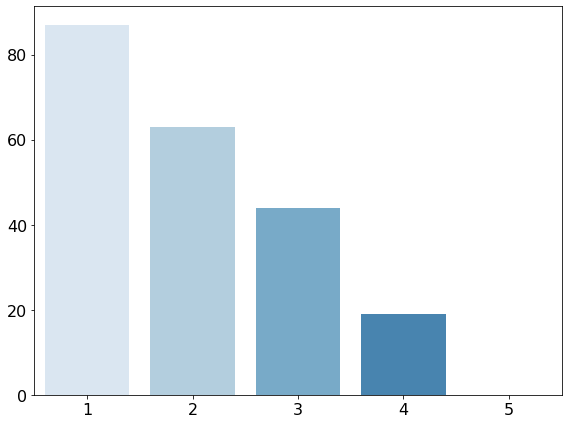

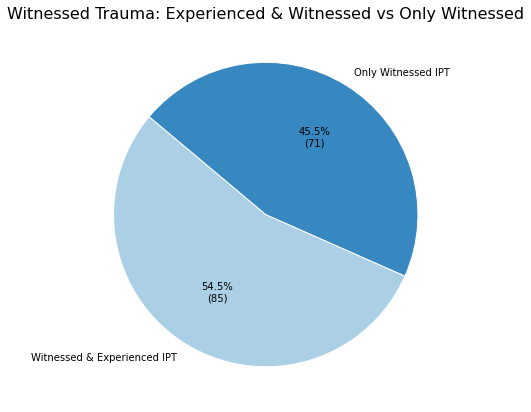

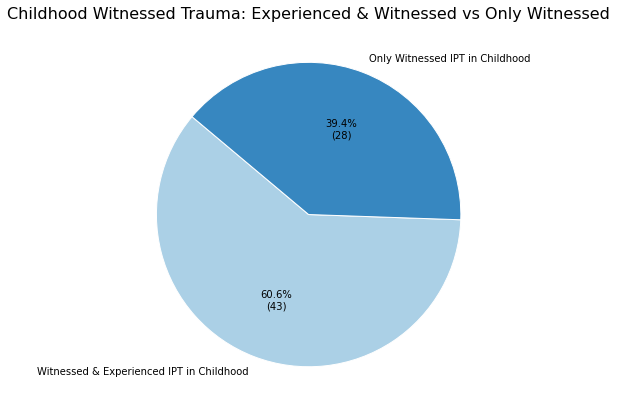

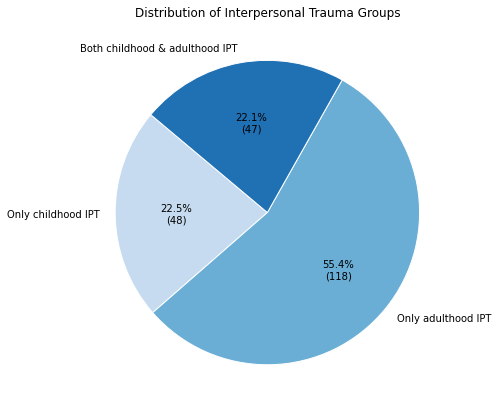

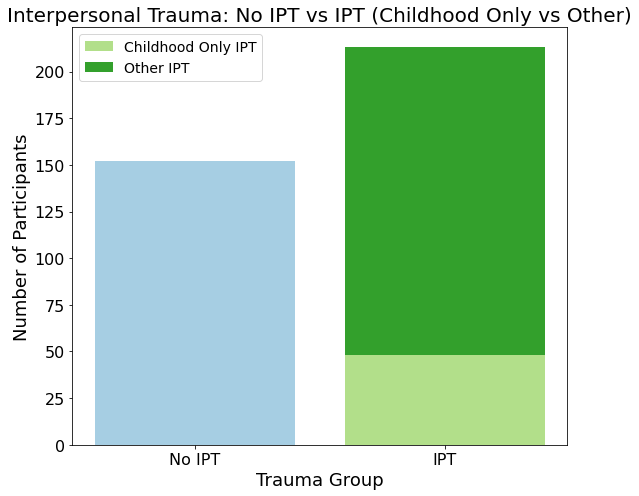

In [ ]:

# 2. Bar plot: Distribution of number of interpersonal traumas
plt.figure(figsize=(8,6))
trauma_counts = [(lec_df['interpersonal_load_trunc'] == n).sum() for n in range(1,6)]
sns.barplot(x=list(range(1,6)), y=trauma_counts, palette='Blues')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('dist.svg', format='svg') 
plt.show()

# Pie chart: witnessed trauma split into "witnessed & experienced" vs "only witnessed"

mask_witnessed = lec_df['interpersonal_witnessed'] > 0
mask_experienced_and_witnessed = lec_df['experienced_and_witnessed'] > 0
mask_only_witnessed = mask_witnessed & ~mask_experienced_and_witnessed

pie_labels = [
    "Witnessed & Experienced IPT",
    "Only Witnessed IPT"
]
pie_counts = [
    mask_experienced_and_witnessed.sum(),
    mask_only_witnessed.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts,
    labels=pie_labels,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=2),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Witnessed Trauma: Experienced & Witnessed vs Only Witnessed", fontsize=16)
plt.show()

# Pie chart: witnessed trauma in childhood split into "witnessed & experienced in childhood" vs "only witnessed in childhood"

mask_witnessed_child = lec_df['ipt_witnessed_childhood'] > 0
mask_experienced_and_witnessed_child = lec_df['experienced_and_witnessed_childhood'] > 0
mask_only_witnessed_child = mask_witnessed_child & ~mask_experienced_and_witnessed_child

pie_labels_child = [
    "Witnessed & Experienced IPT in Childhood",
    "Only Witnessed IPT in Childhood"
]
pie_counts_child = [
    mask_experienced_and_witnessed_child.sum(),
    mask_only_witnessed_child.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts_child,
    labels=pie_labels_child,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts_child)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=2),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Childhood Witnessed Trauma: Experienced & Witnessed vs Only Witnessed", fontsize=16)
plt.show()
# Pie chart for mutually exclusive IPT groups with numbers on slices

pie_labels = [
    "Only childhood IPT",
    "Only adulthood IPT",
    "Both childhood & adulthood IPT"
]
pie_counts = [
    only_childhood.sum(),
    only_adulthood.sum(),
    both_child_and_adult.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts,
    labels=pie_labels,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=3),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Distribution of Interpersonal Trauma Groups")
plt.show()
# Bar plot: IPT vs No IPT, with IPT split into "Childhood Only" and "Other" (within IPT group)

import matplotlib.pyplot as plt
import seaborn as sns

# Masks
no_ipt_mask = lec_df['interpersonal_load'] == 0
ipt_mask = lec_df['interpersonal_load'] > 0
child_only_mask = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] == 0) & ipt_mask
other_ipt_mask = ipt_mask & ~child_only_mask

# Counts
n_no_ipt = no_ipt_mask.sum()
n_ipt = ipt_mask.sum()
n_child_only = child_only_mask.sum()
n_other_ipt = other_ipt_mask.sum()

# Stacked bar plot data
ipt_subgroups = [n_child_only, n_other_ipt]

plt.figure(figsize=(8,7))
bars = plt.bar(['No IPT', 'IPT'], [n_no_ipt, n_ipt], color=['#a6cee3', '#1f78b4'])
plt.bar('IPT', n_child_only, color='#b2df8a', label='Childhood Only IPT')
plt.bar('IPT', n_other_ipt, bottom=n_child_only, color='#33a02c', label='Other IPT')

plt.ylabel('Number of Participants', fontsize=18)
plt.xlabel('Trauma Group', fontsize=18)
plt.title('Interpersonal Trauma: No IPT vs IPT (Childhood Only vs Other)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

<span style="font-size: 48px;">6: Initial Offer x IPT Load</span>


In [ ]:
#see if there is an effect of chronicity of ipt load on socially specific lr, softmax, and bias
#then we do the same thing with the childhood trauma questionaire
#good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#merged_df = merged_df.loc[good_candidates]
# Merge on PID to align interpersonal_load and socially specific LR
merged_df = pd.merge(
    allLrnSumm,
    lec_df[['interpersonal_load', 'interpersonal_childhood', 'interpersonal_load_trunc', 'interpersonal_childhood_trunc','interpersonal_chronicity']],
    left_index=True,
    right_index=True
)
valid_candidates = merged_df.index.intersection(good_candidates)
merged_df = merged_df.loc[valid_candidates]

# Group socially-specific softmaxs by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjSM_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjSM_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean softmax (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean softmax (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: n = {len(group_no_ipt) + len(group_any_ipt)}, t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")


Mean initial offer (no IPT): 1.920 ± 2.076
Mean initial offer (any IPT): 1.847 ± 1.899
Independent samples t-test: n = 365, t=0.35, p=0.729, Cohen's d=0.037


C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/180914829.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


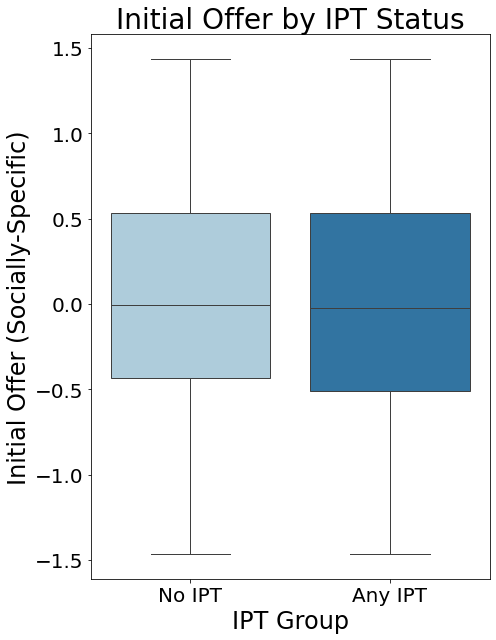

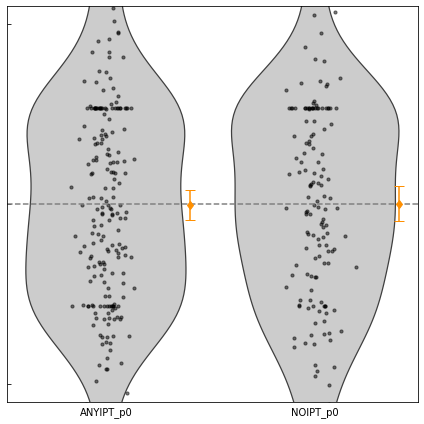

In [ ]:

# Calculate SEM
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
violinplot_df = pd.DataFrame({
    
    'NOIPT_p0' : merged_df[merged_df['interpersonal_load'] == 0]['subjSM_predsoc'],
    'ANYIPT_p0': merged_df[merged_df['interpersonal_load'] > 0]['subjSM_predsoc'],
})
violinplot_df2 = pd.DataFrame({
    
    'NOIPT_LR' : merged_df[merged_df['interpersonal_load'] == 0]['subjLR_3prm_predsoc'],
    'ANYIPT_LR': merged_df[merged_df['interpersonal_load'] > 0]['subjLR_3prm_predsoc'],
})
violinplot_df3 = pd.DataFrame({
    
    'NOIPT_D' : merged_df[merged_df['interpersonal_load'] == 0]['subjD_3prm_predsoc'],
    'ANYIPT_D': merged_df[merged_df['interpersonal_load'] > 0]['subjD_3prm_predsoc'],
})
# make into a df
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjSM_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjSM_predsoc']


plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('softmax (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('softmax by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('P0IPT.svg', format='svg') 
plt.show()


plot_violin_with_jitter_and_ci(violinplot_df[['ANYIPT_p0','NOIPT_p0']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(violinplot_df2[['ANYIPT_LR','NOIPT_LR']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(violinplot_df3[['ANYIPT_D','NOIPT_D']], ylim=[-1.1,1.1], yticks=[-1,0,1])

 # <-- Export as SVG

<span style="font-size: 48px;">7: softmax x Interpersonal Load Regression</span>


In [ ]:
# Build regression DataFrame for softmaxs (socially-specific)
regression_df = pd.DataFrame({
    'init_offer_predsoc': merged_df['subjSM_predsoc'],
    
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr



# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc']])
y_std = scaler.fit_transform(regression_df[['init_offer_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (w/ race sex etc): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load','interpersonal_childhood']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (with child IPT): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load','interpersonal_childhood', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (with child IPT and demographics): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

Correlation (trust_rat_mean vs init_offer_predsoc): r=-0.042, p=0.538
trust x  softmax: -0.042, p=0.538
Unadjusted regression standardized beta: -0.077, p=0.267

Adjusted regression standardized beta (w/ race sex etc): -0.058, p=0.41

Adjusted regression standardized beta (with child IPT): -0.091, p=0.23

Adjusted regression standardized beta (with child IPT and demographics): -0.080, p=0.303


<span style="font-size: 48px;">8: softmax x Childhood Trauma</span>


In [ ]:

# Group socially-specific softmaxs by IPT status
group_no_childhood = merged_df[merged_df['interpersonal_childhood'] == 0]['subjSM_predsoc']
group_any_childhood = merged_df[merged_df['interpersonal_childhood'] > 0]['subjSM_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_childhood = group_no_childhood.mean()
sd_no_childhood = group_no_childhood.std()
mean_any_childhood = group_any_childhood.mean()
sd_any_childhood = group_any_childhood.std()
t_stat, p_val = ttest_ind(group_no_childhood, group_any_childhood, nan_policy='omit')
d = cohens_d(group_no_childhood, group_any_childhood)

print(f"Mean softmax (no childhood IPT): {mean_no_childhood:.3f} ± {sd_no_childhood:.3f}")
print(f"Mean softmax (any childhood IPT): {mean_any_childhood:.3f} ± {sd_any_childhood:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")


Mean softmax (no childhood IPT): 1.867 ± 1.990
Mean softmax (any childhood IPT): 1.906 ± 1.930
Independent samples t-test: t=-0.16, p=0.871, Cohen's d=-0.019


/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/1539038448.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


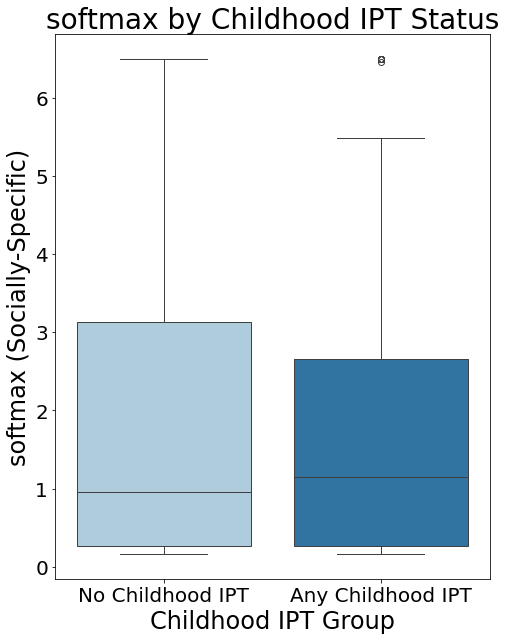

<Figure size 432x288 with 0 Axes>

In [ ]:
# Calculate SEM
n_no_childhood = len(group_no_childhood)
n_any_childhood = len(group_any_childhood)
plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No Childhood IPT'] * n_no_childhood + ['Any Childhood IPT'] * n_any_childhood,
    y=pd.concat([group_no_childhood, group_any_childhood]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('softmax (Socially-Specific)', fontsize=24)
plt.xlabel('Childhood IPT Group', fontsize=24)
plt.title('softmax by Childhood IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
plt.savefig('P0IPT.svg', format='svg')  # <-- Export as SVG

<span style="font-size: 48px;">9: Initial Offer x Childhood Trauma Regression</span>


In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'init_offer_predsoc': merged_df['subjSM_predsoc'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()
regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['interpersonal_load_trunc']])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")


# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler


def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: init_offer_predsoc")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: init_offer_predsoc")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")
run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
chronic_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] > 0)
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
acute_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] == 0)
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: init_offer_predsoc")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")


Childhood IPT: std. β=-0.053, p=0.615
Adulthood-only IPT: std. β=-0.119, p=0.200
Adult IPT with childhood IPT: std. β=0.044, p=0.670
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: init_offer_predsoc
Adult IPT without childhood IPT: std. β=-0.119, p=0.200
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: init_offer_predsoc
Adult IPT with childhood IPT w/ demos: std. β=0.051, p=0.622
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: init_offer_predsoc
Adult IPT without childhood IPT w/ demos: std. β=-0.113, p=0.243
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: init_offer_predsoc
Childhood IPT: std. β=-0.053, p=0.615
Adulthood-only IPT: std. β=-0.119, p=0.200
Chronic IPT: std. β=-0.048, p=0.604
Acute IPT: std. β=0.020, p=0.851
Chronic Childhood IPT: std. β=-0.033, p=0.806
Acute Childhood IPT: std. β=-0.051, p=0.769
Chronic Adulthood IPT: std. β=-0.111, p=0

<span style="font-size: 48px;">10: Learning Rate and IPT</span>

In [ ]:
# Group socially-specific learning rates by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjLR_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjLR_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean LR (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean LR (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: n = {len(group_no_ipt) + len(group_any_ipt)}, t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

Mean LR (no IPT): -0.014 ± 0.226
Mean LR (any IPT): 0.010 ± 0.220
Independent samples t-test: n = 365, t=-0.99, p=0.321, Cohen's d=-0.106


/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/3017733439.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


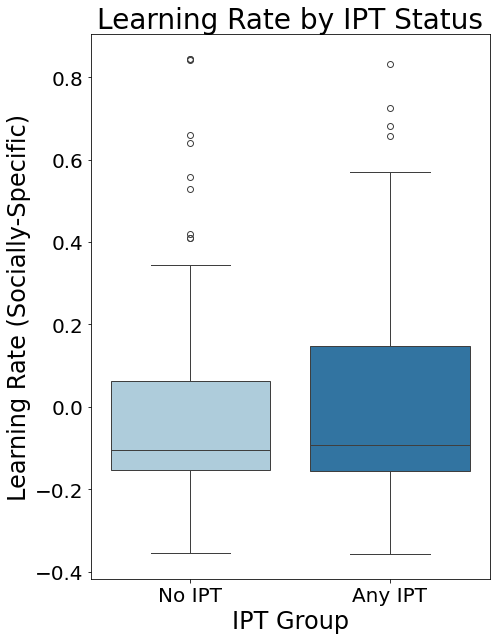

In [ ]:
# Visualize mean socially-specific learning rates for IPT vs no IPT
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
sems = [sd_no_ipt / np.sqrt(n_no_ipt), sd_any_ipt / np.sqrt(n_any_ipt)]

plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Learning Rate (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Learning Rate by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('LRIPT.svg', format='svg')  # <-- Export as SVG
plt.show()


In [ ]:
# Group socially-specific learning rates by IPT age status (childhood vs adulthood-only)

regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_group = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_group = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_childhood = regression_df[childhood_group]['subjLR_3prm'].mean()
sd_childhood = regression_df[childhood_group]['subjLR_3prm'].std()
mean_adulthood = regression_df[adulthood_group]['subjLR_3prm'].mean()
sd_adulthood = regression_df[adulthood_group]['subjLR_3prm'].std()
t_stat, p_val = ttest_ind(regression_df[childhood_group]['subjLR_3prm'], regression_df[adulthood_group]['subjLR_3prm'], nan_policy='omit')
d = cohens_d(regression_df[childhood_group]['subjLR_3prm'], regression_df[adulthood_group]['subjLR_3prm'])

print(f"Mean LR (childhood IPT): {mean_childhood:.3f} ± {sd_childhood:.3f}")
print(f"Mean LR (adulthood IPT): {mean_adulthood:.3f} ± {sd_adulthood:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

Mean LR (childhood IPT): 0.020 ± 0.221
Mean LR (adulthood IPT): 0.002 ± 0.219
Independent samples t-test: t=0.60, p=0.550, Cohen's d=0.083


In [ ]:


# adult with childhood trauma
adulthood_w_childhood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] > 0)

#adult without childhood trauma
adulthood_wo_childhood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)
    
adulthood_w_childhood = regression_df[adulthood_w_childhood_mask]['subjLR_3prm']
adulthood_wo_childhood = regression_df[adulthood_wo_childhood_mask]['subjLR_3prm']

adulthood_w_childhood.mean(), adulthood_wo_childhood.mean()
print(f"Mean LR (adulthood IPT with childhood IPT): {adulthood_w_childhood.mean():.3f} ± {adulthood_w_childhood.std():.3f}")
print(f"Mean LR (adulthood IPT without childhood IPT): {adulthood_wo_childhood.mean():.3f} ± {adulthood_wo_childhood.std():.3f}")
# Independent samples t-test
print(adulthood_w_childhood.shape, adulthood_wo_childhood.shape)


t_stat, p_val = ttest_ind(adulthood_w_childhood, adulthood_wo_childhood, nan_policy='omit')
print(f"t-test: t={t_stat:.2f}, p={p_val:.3f}")

Mean LR (adulthood IPT with childhood IPT): 0.020 ± 0.221
Mean LR (adulthood IPT without childhood IPT): 0.002 ± 0.219
(94,) (118,)
t-test: t=0.60, p=0.550


<span style="font-size: 48px;">11: IPT X Learning Rate Regression</span>


In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'LR_predsoc': merged_df['subjLR_3prm_predsoc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load']])
y_std = scaler.fit_transform(regression_df[['LR_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (interpersonal_load): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

Unadjusted regression standardized beta: -0.112, p=0.104

Adjusted regression standardized beta (interpersonal_load): -0.121, p=0.0909


<span style="font-size: 48px;">12: Social alone x LRs</span>


In [ ]:
# Build regression DataFrame for Learning Rates (social ALONE)
regression_df = pd.DataFrame({
    'subjLR_3prm': oneLRTRUST['subjLR'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load']])
y_std = scaler.fit_transform(regression_df[['subjLR_3prm']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (interpersonal_load): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())

Unadjusted regression standardized beta: -0.124, p=0.0717
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.277
Date:                Mon, 09 Feb 2026   Prob (F-statistic):             0.0717
Time:                        16:05:33   Log-Likelihood:                -299.17
No. Observations:                 212   AIC:                             602.3
Df Residuals:                     210   BIC:                             609.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

<span style="font-size: 48px;">13: Child IPT X Social Alone </span>


In [ ]:

regression_df = pd.DataFrame({
    'subjLR_3prm': oneLRTRUST['subjLR'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

# Group social alone learning rates by childhood IPT status
group_no_ipt = regression_df[regression_df['interpersonal_childhood'] == 0]['subjLR_3prm']
group_any_ipt = regression_df[regression_df['interpersonal_childhood'] > 0]['subjLR_3prm']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean LR (no child IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean LR (any child IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")



Mean LR (no child IPT): 0.180 ± 0.228
Mean LR (any child IPT): 0.209 ± 0.229
Independent samples t-test: t=-1.05, p=0.296, Cohen's d=-0.126


<span style="font-size: 48px;">14: Child IPT X Learning Rate Regression</span>


Childhood IPT: std. β=-0.217, p=0.036
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Adulthood-only IPT: std. β=-0.029, p=0.753
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic IPT: std. β=-0.102, p=0.272
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute IPT: std. β=-0.031, p=0.767
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic Childhood IPT: std. β=-0.203, p=0.122
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute Childhood IPT: std. β=-0.210, p=0.225
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic Adulthood IPT: std. β=0.075, p=0.585
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute Adulthood IPT: std. β=-0.073, p=0.568
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Childhood IPT w/ demos: std. β=-0.214, p=0.048
Predictor(s): ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcom

/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/61489539.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


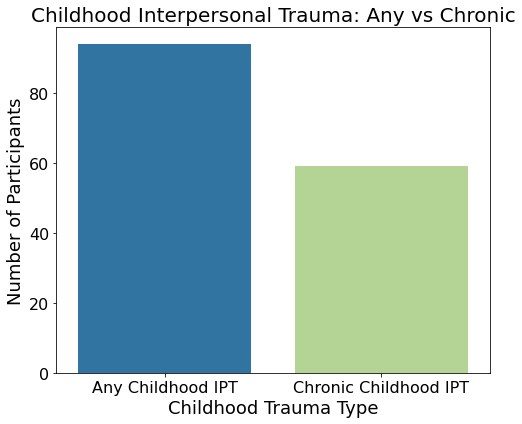

In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")
    #print(model.summary())


# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
chronic_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] > 0)
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
acute_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] == 0)
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")

#of those with chronic trauma, how much had any childhood trauma
import seaborn as sns

# Count participants with any childhood IPT and chronic childhood IPT
n_childhood = (regression_df['interpersonal_childhood_trunc'] > 0).sum()
n_chronic_childhood = (regression_df['chronic_childhood_interpersonal'] > 0).sum()

print(n_childhood)
print(n_chronic_childhood)

plt.figure(figsize=(7,6))
sns.barplot(
    x=['Any Childhood IPT', 'Chronic Childhood IPT'],
    y=[n_childhood, n_chronic_childhood],
    palette=['#1f78b4', '#b2df8a']
)
plt.ylabel('Number of Participants', fontsize=18)
plt.xlabel('Childhood Trauma Type', fontsize=18)
plt.title('Childhood Interpersonal Trauma: Any vs Chronic', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#Apparently, a strong predictor of if Adult IPT will be associated with learning rate 
# is whether the individual also experienced childhood IPT

regression_df = pd.DataFrame({
   
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],

    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],

    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],


    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()


# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0) 
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

childhood_only_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['interpersonal_adult_load_trunc'] == 0)
regression_df = regression_df[regression_df['interpersonal_adult_load_trunc'] > 0]

def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())

def run_standardized_reg_child(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_childhood_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())

def run_standardized_reg_child_demos(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_childhood_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")

run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")

run_standardized_reg_child(regression_df[childhood_mask], "Childhood IPT")

run_standardized_reg_child_demos(regression_df[childhood_mask], "Childhood IPT w/ demos")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")

run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")


Adult IPT with childhood IPT: std. β=-0.344, p=0.019
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjLR_3prm
Adult IPT without childhood IPT: std. β=-0.029, p=0.753
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjLR_3prm
Childhood IPT: std. β=-0.330, p=0.025
Predictor(s): ['interpersonal_childhood_trunc'] | Outcome: subjLR_3prm
Childhood IPT w/ demos: std. β=-0.388, p=0.010
Predictor(s): ['interpersonal_childhood_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm
Adult IPT with childhood IPT w/ demos: std. β=-0.288, p=0.070
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm
Adult IPT without childhood IPT w/ demos: std. β=-0.063, p=0.525
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm


/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/2299728665.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/2299728665.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")
/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/2299728665.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_child(regression_df[childhood_mask], "Childhood IPT")
/var/folders/r7/885jk66570b7thwvw1cqtdth0000gq/T/ipykernel_12938/2299728665.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_child_demos(regression_df[childhood_mask], "Childhood IPT w/ demos")
/var/fol

In [ ]:
len(regression_df[adulthood_mask])

C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/1071498377.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(regression_df[adulthood_mask])


118

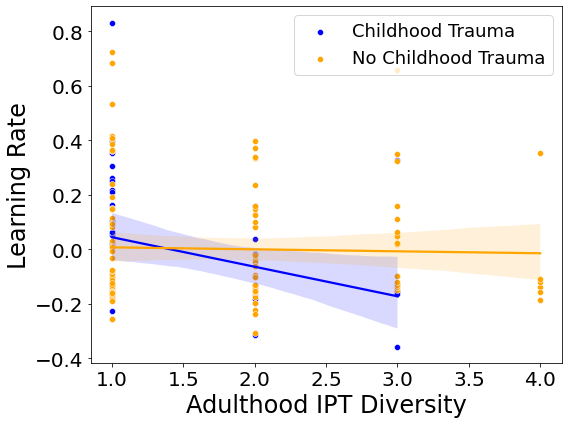

94 118


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[childhood_mask, 'subjLR_3prm'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[adulthood_mask, 'subjLR_3prm'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[childhood_mask, 'subjLR_3prm'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[adulthood_mask, 'subjLR_3prm'],
    scatter=False, color='orange'
)

plt.xlabel('Adulthood IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('adultCtrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

print(childhood_mask.sum(), adulthood_mask.sum())

In [ ]:
# Chronic childhood IPT: chronic_childhood_interpersonal > 0
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0

# Acute childhood IPT: interpersonal_childhood_trunc > 0 and chronic_childhood_interpersonal == 0
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)

# Compare mean learning rates for chronic vs acute childhood IPT
group_chronic = regression_df[chronic_child_mask]['subjLR_3prm']
group_acute = regression_df[acute_child_mask]['subjLR_3prm']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

mean_chronic = group_chronic.mean()
sd_chronic = group_chronic.std()
mean_acute = group_acute.mean()
sd_acute = group_acute.std()
t_stat, p_val = ttest_ind(group_chronic, group_acute, nan_policy='omit')
d = cohens_d(group_chronic, group_acute)

print(f"Mean LR (chronic childhood IPT): {mean_chronic:.3f} ± {sd_chronic:.3f}")
print(f"Mean LR (acute childhood IPT): {mean_acute:.3f} ± {sd_acute:.3f}")
print(f"t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,6))
sns.barplot(
    x=['Chronic Childhood IPT', 'Acute Childhood IPT'],
    y=[mean_chronic, mean_acute],
    palette=['#b2df8a', '#1f78b4']
)
plt.errorbar(
    x=[0, 1],
    y=[mean_chronic, mean_acute],
    yerr=[sd_chronic, sd_acute],
    fmt='none',
    ecolor='black',
    capsize=8,
    linewidth=2
)
plt.ylabel('Mean Learning Rate', fontsize=18)
plt.xlabel('Childhood Trauma Type', fontsize=18)
plt.title('Learning Rate: Chronic vs Acute Childhood IPT', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

KeyError: 'chronic_childhood_interpersonal'

In [ ]:
print(allLrnSumm.columns)

Index(['subjLR_3prm_predsoc', 'subjD_3prm_predsoc', 'subjp0_3prm_predsoc',
       'subjNLL_3prm_predsoc', 'subjLRTp_3prm_predsoc'],
      dtype='object')


In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'subjD_3prm':allLrnSumm['subjD_3prm_predsoc'],
    'subjp0_3prm': allLrnSumm['subjSM_predsoc'],
    'CTQ' :CTQTot,
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['CTQ']])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df, "CTQTot")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['CTQ', 'BirthSex', 'Race', 'HLS_ethnicity','Age']])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(model.summary())

run_standardized_reg_demo(regression_df, "CTQ + Demographics")

CTQTot: std. β=0.119, p=0.040
CTQ + Demographics: std. β=0.094, p=0.123


In [ ]:
from sklearn.preprocessing import StandardScaler

# Convert categorical variables to dummies
df = regression_df.copy()


outcomes = ['subjLR_3prm', 'subjD_3prm', 'subjp0_3prm']
predictor = ['CTQ']
predictors = ['CTQ', 'BirthSex', 'Race', 'HLS_ethnicity','Age']

for outcome in outcomes:
    scaler = StandardScaler()
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[[outcome]]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # CTQ standardized beta
    pval = model.pvalues[1]
    print(f"{outcome} ~ CTQ + std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())



for outcome in outcomes:
    scaler = StandardScaler()
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[[outcome]]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # CTQ standardized beta
    pval = model.pvalues[1]
    print(f"{outcome} ~ CTQ + Demographics std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

subjLR_3prm ~ CTQ + std. β=0.119, p=0.040
subjD_3prm ~ CTQ + std. β=-0.004, p=0.944
subjp0_3prm ~ CTQ + std. β=0.053, p=0.360
subjLR_3prm ~ CTQ + Demographics std. β=0.094, p=0.123
subjD_3prm ~ CTQ + Demographics std. β=-0.067, p=0.271
subjp0_3prm ~ CTQ + Demographics std. β=0.120, p=0.047


<span style="font-size: 48px;">15: Child IPT X Learning Rate Mixed Effects</span>

In [ ]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult': lec_df['interpersonal_adult_trunc'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) | (regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)



                                                df    sum_sq   mean_sq  \
interpersonal_childhood                        1.0  0.000382  0.000382   
interpersonal_adult                            1.0  0.292562  0.292562   
interpersonal_childhood:interpersonal_adult    1.0  0.454104  0.454104   
Residual                                     208.0  9.661779  0.046451   

                                                    F    PR(>F)  
interpersonal_childhood                      0.008230  0.927801  
interpersonal_adult                          6.298310  0.012848  
interpersonal_childhood:interpersonal_adult  9.776006  0.002021  
Residual                                          NaN       NaN  


In [ ]:
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    #mask the ipt child yn to only include IPT 0s
    'interpersonal_childhood': lec_df['IPT_child_yn'],
    'interpersonal_adult': lec_df['interpersonal_load'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)



#did i use the wrong interpersonal chid hood

                                                df    sum_sq   mean_sq  \
interpersonal_childhood                        1.0  0.000165  0.000165   
interpersonal_adult                            1.0  0.272038  0.272038   
interpersonal_childhood:interpersonal_adult    1.0  0.142574  0.142574   
Residual                                     208.0  9.994050  0.048048   

                                                    F    PR(>F)  
interpersonal_childhood                      0.003439  0.953291  
interpersonal_adult                          5.661756  0.018243  
interpersonal_childhood:interpersonal_adult  2.967302  0.086450  
Residual                                          NaN       NaN  


In [ ]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': CTQTot,
    'interpersonal_adult': lec_df['interpersonal_adult_trunc'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) | (regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)


                                                df     sum_sq   mean_sq  \
interpersonal_childhood                        1.0   0.213360  0.213360   
interpersonal_adult                            1.0   0.013953  0.013953   
interpersonal_childhood:interpersonal_adult    1.0   0.340968  0.340968   
Residual                                     292.0  14.401009  0.049319   

                                                    F    PR(>F)  
interpersonal_childhood                      4.326159  0.038403  
interpersonal_adult                          0.282919  0.595199  
interpersonal_childhood:interpersonal_adult  6.913597  0.009007  
Residual                                          NaN       NaN  


In [ ]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': CTQTot,
    
}).dropna()

regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) ]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)


                            df     sum_sq  mean_sq         F    PR(>F)
interpersonal_childhood    1.0   0.213360  0.21336  4.251021  0.040105
Residual                 294.0  14.755931  0.05019       NaN       NaN


<span style="font-size: 48px;">15: Plot</span>

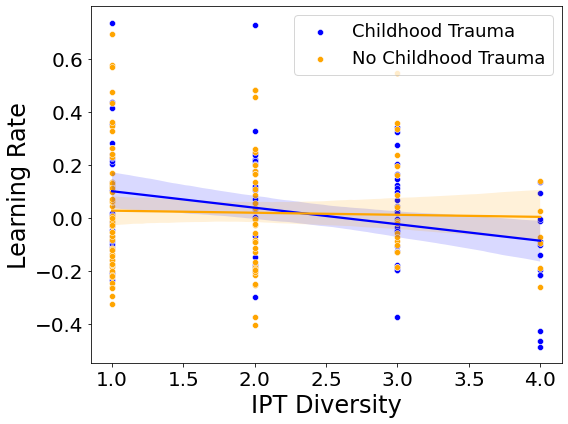

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    scatter=False, color='orange'
)

plt.xlabel('IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

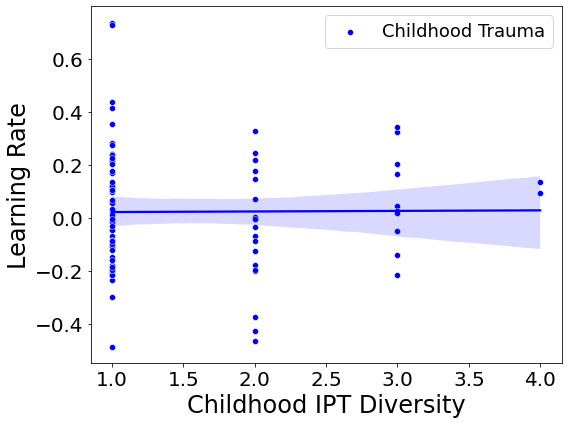

In [ ]:
#CHILDHOOD IPT 


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
   
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_childhood'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_childhood'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)

plt.xlabel('Childhood IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    scatter=False, color='orange'
)

plt.xlabel('IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

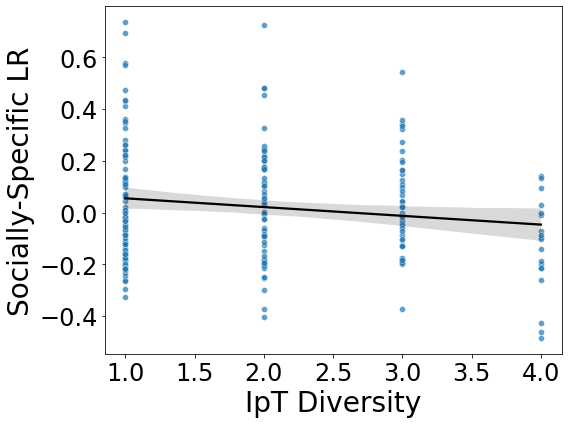

In [ ]:
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
}).dropna()

regression_df = regression_df[(regression_df['interpersonal_load'] > 0)]

# Plot overall trauma load vs. socially-specific learning rate (no group split)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df['interpersonal_load'],
    y=regression_df['LR_predsoc'],
    color='#1f78b4',  # blue
    alpha=0.7
)
sns.regplot(
    x=regression_df['interpersonal_load'],
    y=regression_df['LR_predsoc'],
    scatter=False,
    color='black'
)

plt.xlabel('IpT Diversity', fontsize=28)
plt.ylabel('Socially-Specific LR', fontsize=28)
#plt.title('Trauma Load vs. Learning Rate', fontsize=32)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('trauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

In [ ]:
#sanity check using damians data

damdat = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\AndreaDissertationDataset.csv")



def happened_in_childhood1(val, age):
    if pd.isnull(val) or pd.isnull(age):
        return 0
    try:
        if int(val) == 0 and float(age) < 18:
            return 9
        return int(contains_1(val) and float(age) < 18)
    except:
        return 0


lec_cols_interest1 = ['LECA_6', 'LECA_7',  'LECA_8',  'LECA_9', 'LECA_10', 'LECA_11', 'LECA_17']
lec_age_cols1 = ['LEC6FUAge', 'LEC7FUAge', 'LEC8FUAge', 'LEC9FUAge', 'LEC10FUAge', 'LEC11FUAge', 'LEC16FUAge']
damdat['interpersonal_childhood'] = [
    sum(happened_in_childhood1(row[lec_col], row[age_col]) for lec_col, age_col in zip(lec_cols_interest1, lec_age_cols1))
    for _, row in damdat.iterrows()
]
count = (damdat['interpersonal_childhood'] == 9 ).sum()
print(count)

17


<span style="font-size: 48px;">16: Bias and IPT Regressions</span>

Mean bias (no IPT): 0.203 ± 0.335
Mean bias (any IPT): 0.220 ± 0.340
Independent samples t-test: t=-0.46, p=0.644, Cohen's d=-0.049


C:\Users\mnand\AppData\Local\Temp/ipykernel_47008/1530747419.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


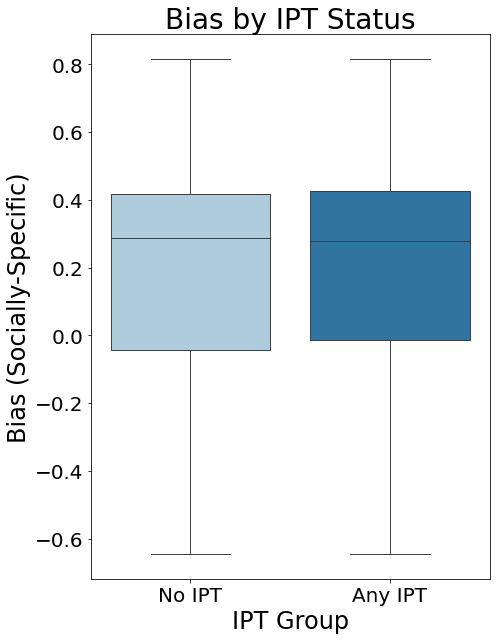

In [ ]:
merged_df = pd.merge(
    allLrnSumm,
    lec_df[['interpersonal_load', 'interpersonal_childhood', 'interpersonal_load_trunc', 'interpersonal_childhood_trunc','interpersonal_chronicity']],
    left_index=True,
    right_index=True
)
valid_candidates = merged_df.index.intersection(good_candidates)
merged_df = merged_df.loc[valid_candidates]

# Group socially-specific initial offers by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjD_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjD_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean bias (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean bias (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")
# Calculate SEM
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Bias (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Bias by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('DIPT.svg', format='svg')  # <-- Export as SVG
plt.show()


## PRINCIPLE COMPONENT ANALYSES OF PTSD SCALES

In [ ]:
## need to do a PCA on the combined BPD and PTSD symptoms to create a composite score

#qsumm holds the questionnaire summary scores,lets take all PCL and SCID-II BPD columns
BPD_PTSD_df = qDat.loc[:, qDat.columns.str.startswith('PCL')|qDat.columns.str.startswith('SCID-II_BPD')]

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select PCL columns ending in '.2' and SCID-II BPD columns ending in '.1'
pcl_cols = []
for col in BPD_PTSD_df.columns:
    if col.startswith('PCL'):
        try:
            # Extract question number, assuming format like 'PCL5-X.Y'
            question_num = int(col.split('-')[1].split('.')[0])
            
            # For questions 9 and 11-20, take the .3 column
            if (question_num == 9 or (11 <= question_num <= 20)) and col.endswith('.3'):
                pcl_cols.append(col)
            # For other questions, take the .2 column
            elif not (question_num == 9 or (11 <= question_num <= 20)) and col.endswith('.2'):
                pcl_cols.append(col)
        except (IndexError, ValueError):
            # Ignore columns that don't match the expected format
            continue
scid_cols = [col for col in BPD_PTSD_df.columns if col.startswith('SCID-II_BPD') and col.endswith('.1')]
# Combine the selected columns into a new DataFrame for PCA
pca_input_df = BPD_PTSD_df[pcl_cols + scid_cols].copy()


# Replace NaNs with 0s as requested
pca_input_df.fillna(0, inplace=True)

# Standardize the data before applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_input_df)

pca = PCA(n_components=5) 
principal_components = pca.fit_transform(scaled_data)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

item_names = pca_input_df.columns

loading_df = pd.DataFrame(
    loadings,
    index=item_names,          # e.g. PCL5_01, SCID_BPD_03, ...
    columns=[f"PC{i+1}" for i in range(loadings.shape[1])]
)
# Define PTSD items as the first 20 rows and BPD items as the rest
ptsd_items = loading_df.index[:20]
bpd_items = loading_df.index[20:]

max_diff = -1
best_pc = None

# Iterate through the 5 principal components to find the one with the largest difference
for i in range(1, 6):
    pc = f"PC{i}"
    ptsd_mean = loading_df.loc[ptsd_items, pc].mean()
    bpd_mean  = loading_df.loc[bpd_items, pc].mean()
    diff = abs(ptsd_mean - bpd_mean)
    
    print(f"{pc}:")
    print(f"  Mean PTSD Loading: {ptsd_mean:.4f}")
    print(f"  Mean BPD Loading:  {bpd_mean:.4f}")
    print(f"  Absolute Difference: {diff:.4f}\n")

    if diff > max_diff:
        max_diff = diff
        best_pc = pc
print(f"The principal component with the largest difference is {best_pc} with a difference of {max_diff:.4f}")


# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, 
                     columns=[f'PC{i+1}' for i in range(pca.n_components)],
                     index=pca_input_df.index)

# The first principal component (PC1) is used as the composite score
qDat['BPD_PTSD_Comp'] = pc_df['PC1']
qDat['BPD_PTSD_Uniq'] = pc_df['PC2']
# --- Explained Variance ---
print("Explained variance by component: ", pca.explained_variance_ratio_)
print(f"Total variance explained by {pca.n_components} components: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Display the head of the new composite score column
print("\nComposite Score Head:")
print(qDat[['BPD_PTSD_Composite']].head())
#transform the data to actually work with PCA, we want each Q to have a magnitude. So we first take every PCL column ending in .2, and replace NANs with 0s for not experienced
#IMPORTANT: for now, lets only take the .1 col of SCID, but disregard .2, which is a chronicity measure


PC1:
  Mean PTSD Loading: 0.6584
  Mean BPD Loading:  0.5703
  Absolute Difference: 0.0881

PC2:
  Mean PTSD Loading: -0.2023
  Mean BPD Loading:  0.3299
  Absolute Difference: 0.5322

PC3:
  Mean PTSD Loading: -0.0110
  Mean BPD Loading:  0.0286
  Absolute Difference: 0.0396

PC4:
  Mean PTSD Loading: -0.0313
  Mean BPD Loading:  0.0449
  Absolute Difference: 0.0762

PC5:
  Mean PTSD Loading: -0.0280
  Mean BPD Loading:  0.0302
  Absolute Difference: 0.0582

The principal component with the largest difference is PC2 with a difference of 0.5322
Explained variance by component:  [0.39381389 0.08215957 0.04674719 0.04446735 0.03319851]
Total variance explained by 5 components: 60.04%

Composite Score Head:
                          BPD_PTSD_Composite
PROLIFIC_PID                                
5f2f86864fd821374b4367bc           -3.005398
61492ac26b91b5b11ba2c88b            4.023581
60234c1d5a0cf81cba76ce5d           -3.504096
6362aca86b740b1ec4cb6efb           -2.619236
60fcd2b146529d02

In [ ]:
#now that we have a unique and common element, lets combine these for our covariates

In [ ]:
## Learning rate correlations with PC1
from scipy.stats import pearsonr
import pandas as pd

# Create a dataframe for correlation
corr_df = pd.DataFrame({
    'PC1': qDat['BPD_PTSD_Comp'],
    'LR_social_specific': allLrnSumm['subjLR_3prm_predsoc']
})

# Filter for good candidates and drop any missing values
valid_candidates = corr_df.index.intersection(good_candidates)
corr_df = corr_df.loc[valid_candidates].dropna()

# Calculate Pearson correlation
corr, p_value = pearsonr(corr_df['PC1'], corr_df['LR_social_specific'])

print(f"Correlation between PC1 (BPD/PTSD Composite) and Socially-Specific Learning Rate:")
print(f"n = {len(corr_df)}")
print(f"Pearson's r: {corr:.3f}")
print(f"P-value: {p_value:.3g}")

Correlation between PC1 (BPD/PTSD Composite) and Socially-Specific Learning Rate:
n = 363
Pearson's r: -0.015
P-value: 0.783


In [ ]:
from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['PC1']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['LR_social_specific']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: LR_social_specific")
    #print(model.summary())

run_standardized_reg(corr_df, "PC1 predicting LR_social_specific")


PC1 predicting LR_social_specific: std. β=-0.015, p=0.783
Predictor(s): ['PC1'] | Outcome: LR_social_specific


In [ ]:
## Learning rate correlations with PC2
from scipy.stats import pearsonr
import pandas as pd

# Create a dataframe for correlation
corr_df = pd.DataFrame({
    'PC2': qDat['BPD_PTSD_Uniq'],
    'LR_social_specific': allLrnSumm['subjLR_3prm_predsoc']
})

# Filter for good candidates and drop any missing values
valid_candidates = corr_df.index.intersection(good_candidates)
corr_df = corr_df.loc[valid_candidates].dropna()

# Calculate Pearson correlation
corr, p_value = pearsonr(corr_df['PC2'], corr_df['LR_social_specific'])

print(f"Correlation between PC2 (BPD/PTSD Composite) and Socially-Specific Learning Rate:")
print(f"Pearson's r: {corr:.3f}")
print(f"P-value: {p_value:.3g}")

Correlation between PC2 (BPD/PTSD Composite) and Socially-Specific Learning Rate:
Pearson's r: -0.009
P-value: 0.861


In [ ]:

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['PC2']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['LR_social_specific']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: LR_social_specific")
    #print(model.summary())

run_standardized_reg(corr_df, "PC2 predicting LR_social_specific")

PC2 predicting LR_social_specific: std. β=-0.009, p=0.861
Predictor(s): ['PC2'] | Outcome: LR_social_specific


,PID,"0.2,0.65","0.2,0.8","0.35,0.65","0.35,0.8","0.65,0.2","0.8,0.35","0.65,0.35","0.8,0.2"
0,p1,5.0,4.0,3.0,1.0,3.0,4.0,NaN,NaN
1,p1,1.0,1.0,1.0,1.0,4.0,5.0,NaN,NaN
2,p1,1.0,2.0,1.0,1.0,1.0,4.0,NaN,NaN
3,p1,2.0,1.0,2.0,1.0,2.0,4.0,NaN,NaN
4,p1,1.0,1.0,2.0,1.0,2.0,5.0,NaN,NaN


In [ ]:
"""
Cell generated by Data Wrangler.
"""
